## 03MLForecast

# MLB Player Trajectory Modeling

This notebook represents the final modeling stage of the **MLBPlayerTrajectories** project.

Using a cleaned, longitudinal player–season dataset constructed in prior notebooks, the goal here is to model how MLB hitter performance **changes from one season to the next**. Rather than predicting raw performance levels, this notebook frames player evaluation as a **trajectory problem**, focusing on improvement, decline, or stability over time.

All modeling is performed using only information available *before* the prediction season. Outcome metrics from the future season are used exclusively for labeling and evaluation, ensuring a strictly forward-looking framework with no information leakage.

## Objective

The primary objectives of this notebook are to:

- Construct year-over-year player features using prior-season and multi-season history  
- Define interpretable trajectory outcomes based on changes in offensive performance  
- Train models that estimate expected improvement or decline in future seasons  
- Translate model outputs into player-level signals suitable for ranking and visualization  

The final outputs of this notebook are designed to support analytical interpretation and downstream visualization in Power BI.

## Modeling Philosophy

This notebook follows a set of guiding principles:

- **Longitudinal perspective**: Players are modeled across multiple seasons rather than treated as static observations  
- **Process over results**: Underlying skill indicators (plate discipline, contact quality) are used as inputs, while outcome metrics are reserved for labeling  
- **Forward-looking design**: All features are derived strictly from prior seasons to prevent leakage  
- **Interpretability first**: Models prioritize clear drivers and ranking quality over black-box accuracy  
- **Practical framing**: The workflow mirrors how performance forecasting is approached in real baseball analytics contexts  

These principles ensure the analysis remains both technically sound and analytically meaningful.

## Trajectory Framework

Player trajectories are defined using **season-level offensive performance outcomes** evaluated in a multi-year context to reduce noise and short-term volatility.

Rather than directly predicting trajectory labels, the modeling task is framed as a **regression problem** that estimates expected change in offensive performance between seasons. Predicted changes are then mapped into interpretable categories such as:

- **Breakout**: Meaningful improvement relative to prior performance  
- **Decline**: Sustained drop from previous offensive levels  
- **Bounceback**: Recovery following a down season  
- **Stable**: Performance remains within expected historical ranges  

This approach preserves continuous information while still producing intuitive, analyst-friendly outcomes.

## Notebook Scope

This notebook begins with a finalized, cleaned player–season dataset exported from the staging process. No additional SQL operations or raw data ingestion are performed here.

The workflow proceeds through:

1. Year-over-year feature construction  
2. Trajectory target definition  
3. Model training and evaluation  
4. Player-level scoring and interpretation  

The notebook concludes with exportable outputs designed for ranking, comparison, and visualization in Power BI.

## Load Final Player–Season Dataset

We begin by loading the finalized player–season dataset produced in the staging
process. This table represents the core analytical input for all modeling work
in this notebook.

Each row corresponds to a single player–season observation and includes:

- Player identifiers and basic context (name, team, age, playing time)
- Season-level offensive outcomes used for labeling and evaluation
- Prior-season offensive process metrics intended for predictive modeling

This dataset has already been cleaned, joined, and validated in earlier steps.
No additional SQL operations or raw data ingestion are performed here.

In [1]:
import pandas as pd

Dataset = pd.read_csv("../notebooks/data/processed/PlayerSeasonFull.csv")
Dataset.head()

,IDfg,Name,Season,Team,Age,G,PA,wRC+,WAR,OPS,...,K%,BB/K,O-Swing%,Z-Contact%,SwStr%,EV,LA,HardHit%,Barrel%,maxEV
0,15640,Aaron Judge,2022,NYY,30,157,696,206,11.1,1.111,...,0.251,0.63,0.268,0.852,0.118,95.8,14.9,0.611,0.262,118.4
1,9777,Nolan Arenado,2022,STL,31,148,620,149,7.2,0.891,...,0.116,0.72,0.361,0.908,0.086,88.8,21.7,0.389,0.082,111.4
2,11493,Manny Machado,2022,SDP,29,150,644,152,7.1,0.898,...,0.207,0.47,0.342,0.856,0.118,91.5,16.0,0.490,0.098,112.4
3,5417,Jose Altuve,2022,HOU,32,141,604,164,6.9,0.921,...,0.144,0.76,0.314,0.910,0.068,85.9,16.1,0.297,0.077,109.8
4,9218,Paul Goldschmidt,2022,STL,34,151,651,175,6.8,0.981,...,0.217,0.56,0.276,0.818,0.099,90.7,15.7,0.472,0.115,112.3


## Dataset Overview

We perform a brief structural inspection to confirm dataset shape, season coverage,
and column availability before proceeding to feature construction and trajectory
definition.

This step ensures that the data is correctly organized at the player–season level
and ready for longitudinal modeling.

In [2]:
Dataset.shape

(538, 23)

In [3]:
Dataset["Season"].value_counts().sort_index()

Season
2022    130
2023    134
2024    129
2025    145
Name: count, dtype: int64

## Column Overview
We inspect the columns left after the SQL queries and joins are finished.

In [4]:
Dataset.columns.tolist()

['IDfg',
 'Name',
 'Season',
 'Team',
 'Age',
 'G',
 'PA',
 'wRC+',
 'WAR',
 'OPS',
 'wOBA',
 'xwOBA',
 'BB%',
 'K%',
 'BB/K',
 'O-Swing%',
 'Z-Contact%',
 'SwStr%',
 'EV',
 'LA',
 'HardHit%',
 'Barrel%',
 'maxEV']

## Core Fields Sanity Check

We briefly inspect a small subset of identifier and performance fields to confirm data consistency.

In [5]:
Dataset[["IDfg", "Name", "Season", "Age", "PA", "wRC+", "WAR"]].head(10)

,IDfg,Name,Season,Age,PA,wRC+,WAR
0,15640,Aaron Judge,2022,30,696,206,11.1
1,9777,Nolan Arenado,2022,31,620,149,7.2
2,11493,Manny Machado,2022,29,644,152,7.1
3,5417,Jose Altuve,2022,32,604,164,6.9
4,9218,Paul Goldschmidt,2022,34,651,175,6.8
5,5361,Freddie Freeman,2022,32,708,157,6.8
6,11739,J.T. Realmuto,2022,31,562,129,6.7
7,18314,Dansby Swanson,2022,28,696,117,6.6
8,19556,Yordan Alvarez,2022,25,561,185,6.4
9,16252,Trea Turner,2022,29,708,128,6.4


## Dataset Preparation for Longitudinal Modeling

This notebook begins with a cleaned, player–season dataset constructed in prior
steps and exported from the staging process.

Before constructing year-over-year targets, we apply only **structural preparation**
steps required for longitudinal modeling:

- Ensure proper chronological ordering by player and season
- Preserve rookie seasons while allowing year-over-year logic to naturally
  exclude players without prior history
- Avoid performance-based filtering at this stage

Rookie seasons are intentionally retained in the dataset. These observations
will not contribute to year-over-year targets but remain useful for final-season
scoring and dashboard visualization.

In [6]:
# Sort data to ensure proper chronological ordering
Dataset = Dataset.sort_values(["IDfg", "Season"]).reset_index(drop=True)

Dataset.head()

,IDfg,Name,Season,Team,Age,G,PA,wRC+,WAR,OPS,...,K%,BB/K,O-Swing%,Z-Contact%,SwStr%,EV,LA,HardHit%,Barrel%,maxEV
0,2396,Carlos Santana,2022,- - -,36,131,506,102,0.9,0.692,...,0.174,0.81,0.257,0.859,0.083,90.7,15.4,0.449,0.093,111.3
1,2396,Carlos Santana,2023,- - -,37,146,619,101,1.5,0.747,...,0.168,0.63,0.274,0.851,0.093,88.8,12.8,0.364,0.067,111.7
2,2396,Carlos Santana,2024,MIN,38,150,594,113,2.9,0.749,...,0.167,0.66,0.270,0.854,0.092,89.2,16.1,0.399,0.073,113.6
3,2434,Nelson Cruz,2022,WSN,41,124,507,87,-0.5,0.651,...,0.235,0.41,0.352,0.801,0.150,90.9,7.2,0.457,0.093,113.8
4,2967,Tommy Pham,2022,- - -,34,144,622,90,0.7,0.686,...,0.268,0.34,0.255,0.873,0.098,92.2,7.7,0.485,0.079,112.6


### Treatment of Rookie Seasons

Rookie seasons are preserved in the dataset rather than removed upfront.

Year-over-year modeling logic will naturally exclude rookies when constructing
lagged features or performance deltas, since no prior season exists.

This approach keeps the dataset flexible and allows:
- Forward-looking scoring for the most recent season
- Clean filtering at the visualization layer
- Consistent dataset structure across all modeling stages

In [7]:
# Inspect a few rows
Dataset[["IDfg", "Name", "Season", "Age", "PA", "wRC+", "WAR"]].head(10)

,IDfg,Name,Season,Age,PA,wRC+,WAR
0,2396,Carlos Santana,2022,36,506,102,0.9
1,2396,Carlos Santana,2023,37,619,101,1.5
2,2396,Carlos Santana,2024,38,594,113,2.9
3,2434,Nelson Cruz,2022,41,507,87,-0.5
4,2967,Tommy Pham,2022,34,622,90,0.7
5,3473,Anthony Rizzo,2022,32,548,131,2.5
6,5038,Josh Donaldson,2022,36,546,96,1.6
7,5235,Justin Turner,2022,37,532,123,2.3
8,5235,Justin Turner,2023,38,626,116,1.2
9,5235,Justin Turner,2024,39,539,116,1.2


### Dataset State Summary

At this point:

- Each row represents a single player–season
- Seasons are correctly ordered by player
- Rookies are included but will not generate year-over-year targets
- No future information has been introduced
- The dataset is ready for lag feature construction and delta-based targets

This forms the foundation for forward-looking trajectory modeling.

### Next Steps

The next phase of this notebook will focus on transforming the player–season dataset
into a forward-looking modeling framework.

Specifically, we will:

- Create prior-season (lagged) versions of key performance and process metrics  
- Compute year-over-year changes in offensive outcomes to serve as modeling targets  
- Frame the modeling task as prediction of *expected change* in performance rather than absolute level  
- Map predicted changes into interpretable trajectory outcomes such as breakout, decline, bounceback, or stability  

Each step will be implemented incrementally to preserve clarity, maintain chronological
integrity, and prevent information leakage.

## Modeling Eligibility and Forecasting Setup

To model year-over-year change, players must have at least one prior season of data.
Rookies are retained in the dataset for completeness and downstream visualization,
but they will naturally fall out of the modeling sample due to the absence of lagged
features.

The final season in the dataset (2025) is treated as the *forecast season*.
No year-over-year targets are computed for 2025; instead, model predictions generated
from 2024 data will represent expected performance change entering 2026.

## Targeted Exploration of Year-over-Year Change

Before constructing lagged features or fitting any models, we perform a small set of
targeted exploratory checks focused specifically on year-over-year change in offensive
performance.

The goal of this exploration is not exhaustive visualization, but validation that
the modeling target (change in wRC+) behaves in expected ways and is suitable for
forward-looking prediction.

In [8]:
# Ensure proper chronological ordering
Dataset = Dataset.sort_values(["IDfg", "Season"]).reset_index(drop=True)

# Create next-season wRC+ and year-over-year change
Dataset["wRC+Next"] = Dataset.groupby("IDfg")["wRC+"].shift(-1)
Dataset["wRC+Delta"] = Dataset["wRC+Next"] - Dataset["wRC+"]

In [9]:
# Rows eligible for model training
ModelData = Dataset[Dataset["wRC+Delta"].notna()].copy()

ModelData.shape

(287, 25)

## Distribution of Year-over-Year Performance Change

Before defining trajectory outcomes or fitting any models, we examine the
distribution of year-over-year changes in offensive performance.

The modeling target, **wRC+Delta**, represents the change in a player’s
offensive value from one season to the next. Understanding its distribution
is critical for:

- Identifying typical vs extreme changes in performance
- Setting interpretable thresholds for breakout, decline, and stability
- Validating that the modeling task is well-behaved (no heavy skew or artifacts)

This step is exploratory only and does not influence model training.

In [10]:
ModelData["wRC+Delta"].describe()

count    287.000000
mean      -3.017422
std       21.629987
min      -53.000000
25%      -18.000000
50%       -4.000000
75%       10.000000
max       72.000000
Name: wRC+Delta, dtype: float64

<Axes: >

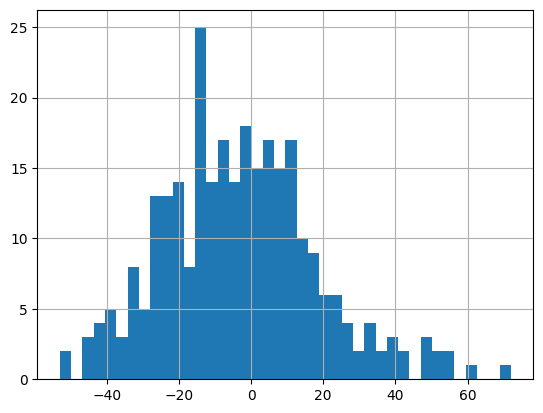

In [11]:
ModelData["wRC+Delta"].hist(bins=40)

### Interpreting wRC+Delta

Most players experience modest year-over-year changes in performance, while
large jumps or collapses are relatively rare.

This reinforces two important modeling decisions:

- Predicting *change* (delta) is more stable than predicting absolute level
- Trajectory labels should be defined relative to the empirical distribution,
  not arbitrary cutoffs

Rather than forcing hard classification boundaries upfront, we will allow
the regression model to estimate expected change, and then map predictions
into trajectory categories using transparent, analyst-defined thresholds.

## Trajectory Definitions

Player trajectories are defined using year-over-year change in offensive
performance, measured by wRC+.

Rather than predicting trajectory labels directly, the model estimates
expected change in wRC+, which is then mapped into interpretable outcomes.

Trajectory categories are defined as follows:

- **Breakout**: Meaningful positive change in wRC+ relative to the player’s
  recent performance baseline.

- **Bounceback**: Positive change following a prior-season decline,
  indicating recovery toward historical performance levels.

- **Decline**: Meaningful negative change in wRC+ relative to recent
  performance, consistent with skill erosion or aging effects.

- **Stable**: Year-over-year change in wRC+ remains within the expected
  historical range, indicating no meaningful performance shift.

All labels are derived from *future-season outcomes*, while all modeling
inputs are restricted to prior-season information to prevent information
leakage.

## Feature Design Philosophy

The objective of this notebook is to estimate *expected change* in offensive
performance, not to re-predict known outcomes.

As a result, model inputs are restricted to **process-oriented indicators**
that describe *how* a player is performing, rather than *what* results
they achieved.

Feature construction follows four guiding principles:

- **Temporal integrity**: All features are derived strictly from information
  available prior to the prediction season.
- **Process over outcomes**: Underlying skill indicators (plate discipline,
  contact quality, batted-ball profile) are preferred over box-score results.
- **Stability over noise**: Metrics with lower year-to-year volatility are
  prioritized to improve signal quality.
- **Redundancy awareness**: Highly collinear or overlapping metrics are avoided
  to preserve interpretability and reduce overfitting risk.

Outcome-based metrics such as wRC+, OPS, and WAR are used exclusively for
target construction and evaluation, and are explicitly excluded from model
inputs.

## Feature Overview and Baseball Context

The modeling features retained after SQL cleaning fall into a small number of
process-oriented categories. Each category captures a distinct component of
offensive skill that may influence future performance change.

## See FeatureContext.md for further explanations

### Plate Discipline

Metrics related to swing decisions and strike-zone judgment.
These features describe how selective a hitter is and how often they expand
the zone, which tend to stabilize earlier in a player’s career and degrade
gradually with age.

### Contact Ability

Metrics capturing a hitter’s ability to make contact when swinging.
These features help distinguish skill erosion from variance-driven slumps.

### Quality of Contact

Batted-ball metrics describing how hard and efficiently a player strikes the ball.
Changes in these metrics often precede visible changes in results.

### Power Ceiling Indicators

Upper-bound contact metrics that reflect a player’s physical upside rather
than average outcomes.

### Contextual Controls

Age and playing-time measures included to contextualize change without
introducing team-level effects.

## Exploratory Data Analysis (EDA)

The purpose of this section is to validate candidate model features prior to
any modeling or feature engineering.

EDA is used here strictly for:
- Understanding feature distributions
- Identifying potential redundancy or collinearity
- Flagging unstable or noisy metrics

This analysis is *not* intended to optimize predictive performance or select
features based on correlation with outcomes.

### Modeling Dataset Overview

We begin by confirming dataset dimensions and basic structure after filtering
to player–seasons eligible for year-over-year analysis.

In [12]:
ModelData.shape

(287, 25)

### Plate Discipline Metrics

Plate discipline metrics describe how frequently a hitter swings, makes
contact, and controls the strike zone. These features are generally more
stable year-over-year than box-score outcomes.

array([[<Axes: title={'center': 'BB%'}>, <Axes: title={'center': 'K%'}>],
       [<Axes: title={'center': 'BB/K'}>,
        <Axes: title={'center': 'O-Swing%'}>],
       [<Axes: title={'center': 'Z-Contact%'}>,
        <Axes: title={'center': 'SwStr%'}>]], dtype=object)

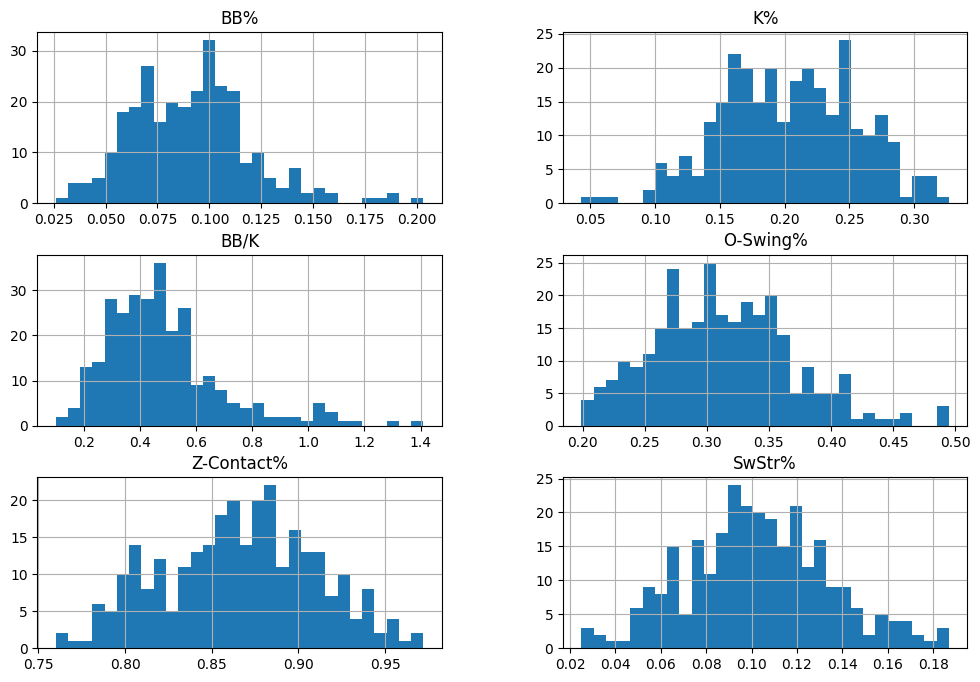

In [13]:
ModelData[[
    "BB%",
    "K%",
    "BB/K",
    "O-Swing%",
    "Z-Contact%",
    "SwStr%"
]].hist(bins=30, figsize=(12,8))

### Contact Quality Metrics

Contact quality metrics capture how hard and how optimally a hitter strikes
the ball when contact is made. These features reflect underlying power and
batted-ball skill rather than results.

array([[<Axes: title={'center': 'EV'}>, <Axes: title={'center': 'LA'}>],
       [<Axes: title={'center': 'HardHit%'}>,
        <Axes: title={'center': 'Barrel%'}>],
       [<Axes: title={'center': 'maxEV'}>, <Axes: >]], dtype=object)

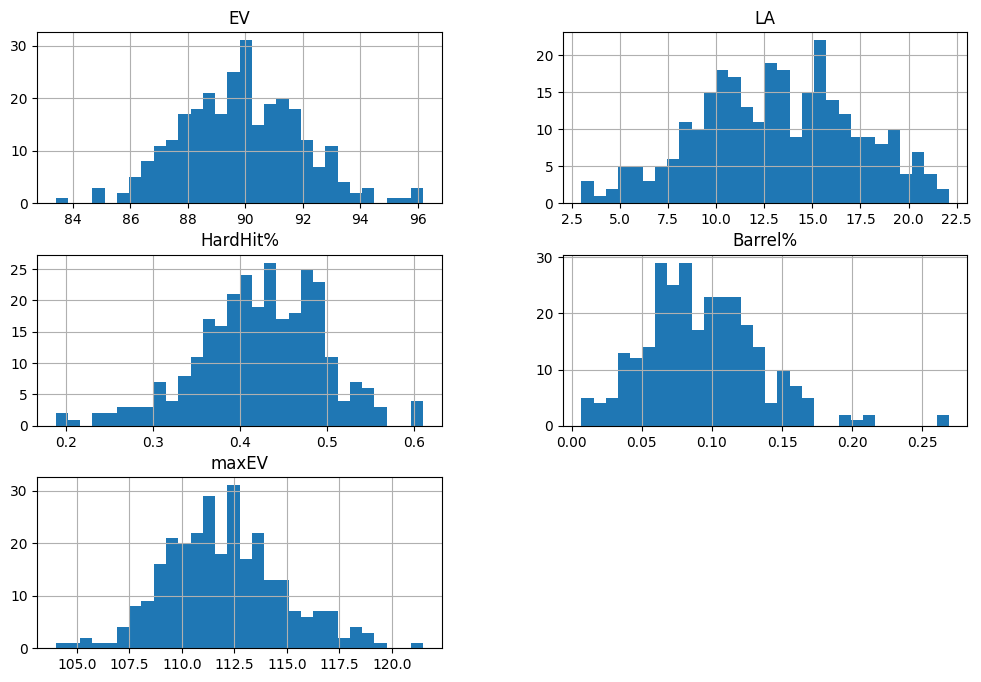

In [14]:
ModelData[[
    "EV",
    "LA",
    "HardHit%",
    "Barrel%",
    "maxEV"
]].hist(bins=30, figsize=(12,8))

### Outcome Metrics (Only used for Context)

Outcome-based metrics such as wRC+, wOBA, OPS, and WAR are included here for
context and validation only. These fields will be used later for target
construction and evaluation, not as model inputs.

array([[<Axes: title={'center': 'wRC+'}>,
        <Axes: title={'center': 'wOBA'}>],
       [<Axes: title={'center': 'OPS'}>, <Axes: title={'center': 'WAR'}>]],
      dtype=object)

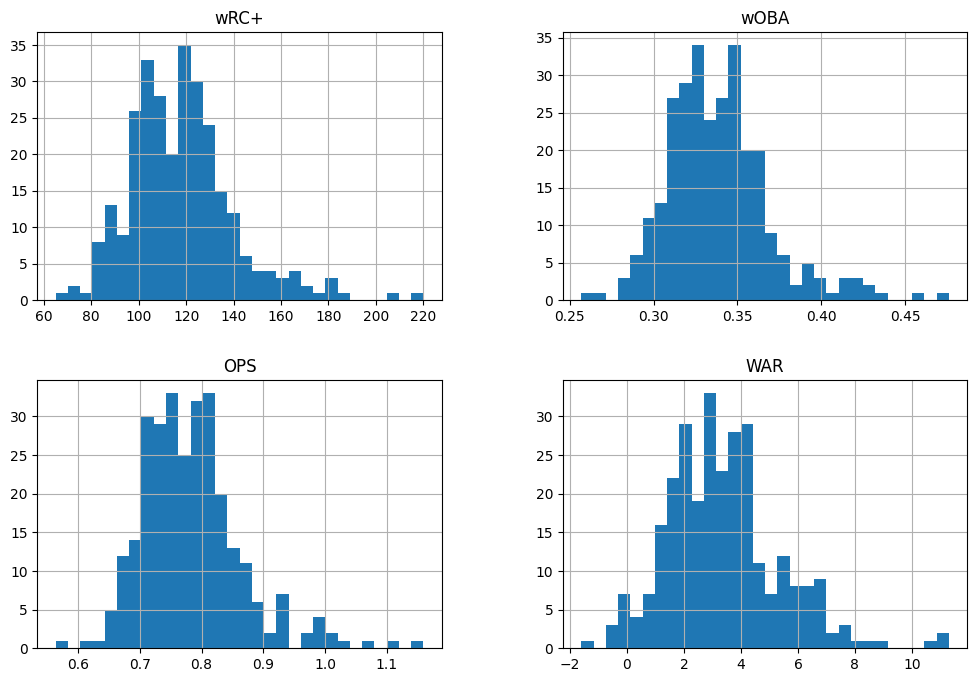

In [15]:
ModelData[[
    "wRC+",
    "wOBA",
    "OPS",
    "WAR"
]].hist(bins=30, figsize=(12,8))

### Feature Correlation Overview

Many offensive metrics measure related underlying skills. We inspect pairwise
correlations to identify groups of potentially redundant features that may
require consolidation or pruning later in the workflow.

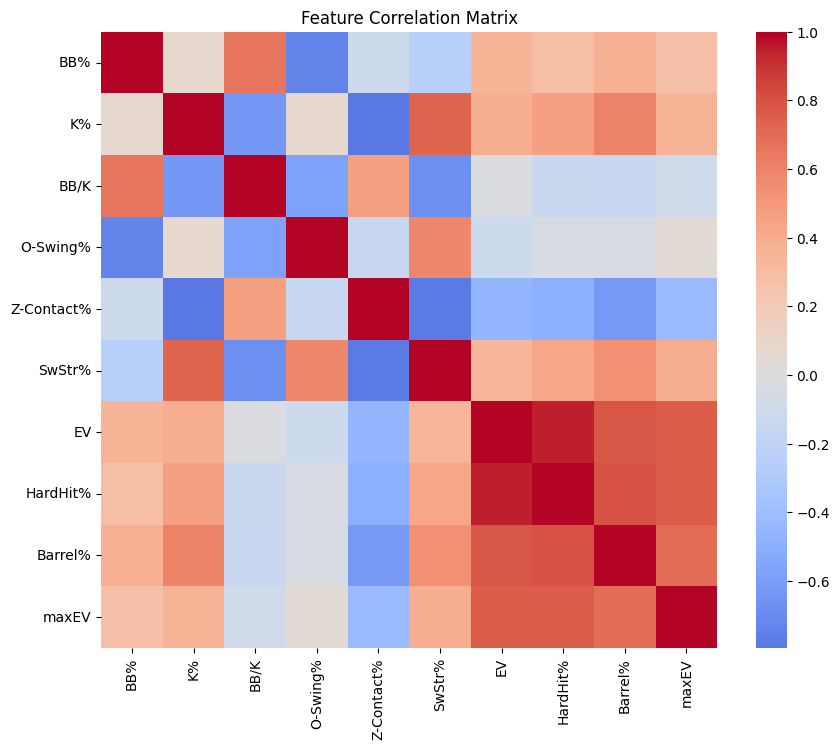

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_features = [
    "BB%",
    "K%",
    "BB/K",
    "O-Swing%",
    "Z-Contact%",
    "SwStr%",
    "EV",
    "HardHit%",
    "Barrel%",
    "maxEV"
]

plt.figure(figsize=(10,8))
sns.heatmap(
    ModelData[corr_features].corr(),
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Feature Correlation Matrix")
plt.show()

## Exploratory Feature Analysis — Key Takeaways

Exploratory analysis reveals clear clustering among candidate features, reflecting
underlying offensive skill dimensions rather than independent signals.

### Plate Discipline Metrics
Metrics such as BB%, K%, BB/K, O-Swing%, Z-Contact%, and SwStr% exhibit strong internal
correlation. This indicates that these variables largely describe the same latent
skill: strike-zone control and bat-to-ball ability.

Rather than including all discipline metrics, a small subset is sufficient to capture
this skill dimension while reducing redundancy and multicollinearity.

### Contact Quality Metrics
EV, HardHit%, Barrel%, and maxEV show extremely high correlation, reflecting different
views of raw power and batted-ball quality. Including all of these would overweight
power-related signal without improving explanatory value.

Barrel% emerges as the most interpretable and stable representation of contact quality,
balancing frequency and outcome quality.

### Skill Independence
Discipline metrics and contact quality metrics show weaker cross-correlation, suggesting
they capture distinct offensive traits. This separation supports modeling expected
performance change as a function of multiple independent skill axes rather than a
single composite score.

### Modeling Implications
Based on these findings, feature selection prioritizes:
- One representative discipline metric
- One representative contact-quality metric
- Avoidance of overlapping or highly collinear inputs

This approach preserves interpretability, reduces overfitting risk, and aligns with
real-world player evaluation practices.

## Final Feature Selection

Based on exploratory analysis and observed correlation structure, a deliberately
small and interpretable feature set is selected to model expected year-over-year
change in offensive performance.

Rather than maximizing feature count, the objective is to represent distinct
underlying skill dimensions while minimizing redundancy, multicollinearity,
and overfitting risk.

### Selected Modeling Features

- **Age**  
  Captures aging effects and non-linear career trajectories that influence
  expected performance change across seasons.

- **Plate Discipline (O-Swing%)**  
  Represents swing decision quality and strike-zone judgment. Elevated chase
  rates are associated with weaker offensive sustainability and increased
  downside risk.

- **Contact Quality (Barrel%)**  
  Serves as a stable, outcome-relevant proxy for power and quality of contact,
  combining exit velocity and launch angle into a single interpretable metric.

### Excluded Metrics

Several metrics are intentionally excluded from model inputs despite their
predictive relevance:

- Outcome-based metrics (wRC+, OPS, WAR)  
- Redundant discipline indicators (BB%, K%, SwStr%)  
- Highly collinear power measures (EV, HardHit%, maxEV)

These variables are retained for evaluation, visualization, and interpretation,
but excluded from modeling to preserve temporal integrity and interpretability.

## Baseline Regression: Sanity Check on Feature Signals

Before introducing more complex models or forecasting future seasons, we begin
with a simple baseline regression to validate directional relationships between
selected process metrics and year-over-year offensive change.

The objective of this step is **not** to maximize predictive performance, but to
confirm that model signals align with baseball intuition and analytical expectations.

Specifically, this regression is used to:

- Verify that aging effects are associated with expected decline
- Confirm that poorer plate discipline (higher O-Swing%) corresponds to negative change
- Confirm that stronger contact quality (higher Barrel%) corresponds to positive change
- Detect any obvious sign reversals or unstable relationships

If feature directions behave as expected, this provides confidence to proceed
with more flexible modeling approaches and future-season forecasting.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Select modeling features and target
features = ["Age", "O-Swing%", "Barrel%"]
target = "wRC+Delta"

X = ModelData[features]
y = ModelData[target]

# Standardize features for coefficient comparability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit baseline regression
model = LinearRegression()
model.fit(X_scaled, y)

# Collect coefficients
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values("Coefficient", ascending=False)

coef_df

,Feature,Coefficient
2,Barrel%,-0.391453
1,O-Swing%,-0.648223
0,Age,-1.695200
